In [6]:
# 1. parquet 엔진(pyarrow, fastparquet) 설치 및 pandas 업데이트
# (이미 설치되어 있어도 버전 호환성을 위해 upgrade 옵션을 줍니다)
!pip install --upgrade pandas pyarrow fastparquet

  Using cached fastparquet-2024.2.0-cp38-cp38-win_amd64.whl (671 kB)
  Using cached cramjam-2.11.0-cp38-cp38-win_amd64.whl (1.7 MB)


In [8]:
# 1. 로드된 파일에 어떤 언어가 있는지 확인
print("📊 파일 내 언어 분포 (상위 20개):")
print(raw_df['language'].value_counts().head(20))

# 2. 'ko' 혹은 'Korean'이 있는지 확인
print("\n🔍 한국어 데이터 존재 여부 확인:")
if 'ko' in raw_df['language'].unique():
    print("✅ 'ko' 코드로 존재합니다.")
elif 'Korean' in raw_df['language'].unique():
    print("⚠️ 'Korean'이라는 이름으로 존재합니다. 코드를 수정해야 합니다.")
else:
    print("❌ 이 파일에는 한국어 데이터가 없습니다. 다른 파일을 받아야 합니다.")

📊 파일 내 언어 분포 (상위 20개):
English       29634
Chinese       15281
Russian        5663
French         1500
Portuguese     1197
Spanish        1080
German          851
Italian         636
Turkish         491
Latin           250
Maori           249
Japanese        232
Nolang          226
Indonesian      219
Persian         187
Arabic          170
Sotho           162
Vietnamese      157
Polish          157
Dutch           149
Name: language, dtype: int64

🔍 한국어 데이터 존재 여부 확인:
⚠️ 'Korean'이라는 이름으로 존재합니다. 코드를 수정해야 합니다.


In [11]:
# 한국어 데이터가 91개 있다고 했으니, 그 중 첫 번째 데이터를 꺼내봅니다.
sample_row = ko_df.iloc[0]
sample_conv = sample_row['conversation']

print(f"🔍 데이터 타입: {type(sample_conv)}")
print(f"📏 데이터 길이: {len(sample_conv) if sample_conv is not None else 'None'}")
print("\n📄 데이터 내용 (앞부분만):")
print(sample_conv)

🔍 데이터 타입: <class 'NoneType'>
📏 데이터 길이: None

📄 데이터 내용 (앞부분만):
None


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
from tqdm import tqdm

# ==========================================
# 1. 한국어 데이터 필터링 (수정됨!)
# ==========================================
# 이미 로드된 raw_df가 있다고 가정합니다.
# 혹시 raw_df가 메모리에서 날아갔다면 파일 로드 부분부터 다시 실행해야 합니다.

if 'raw_df' in locals() and not raw_df.empty:
    # 'ko' -> 'Korean'으로 수정
    ko_df = raw_df[raw_df['language'] == 'Korean']
    print(f"🇰🇷 발견된 한국어 대화 세트: {len(ko_df)}개")

    if len(ko_df) == 0:
        print("❌ 이 파일에는 한국어 데이터가 없습니다.")
    else:
        # ==========================================
        # 2. 데이터 구조 풀기 (Flatten) - [안전장치 추가됨]
        # ==========================================
        print("\n🧹 데이터 전처리 중...")
        data_list = []
        
        for _, row in tqdm(ko_df.iterrows(), total=len(ko_df)):
            conversation = row['conversation'] 
            model_name = row['model']
            
            # [수정 1] 데이터가 아예 None인 경우 건너뛰기 (에러 방지 핵심!)
            if conversation is None:
                continue

            # numpy array 등을 list로 변환
            if hasattr(conversation, 'tolist'):
                conversation = conversation.tolist()
            
            # [수정 2] 변환 후에도 리스트가 아니면 건너뛰기
            if not isinstance(conversation, list):
                continue
                
            for turn in conversation:
                # turn 자체가 None일 수도 있으니 .get 사용
                if turn is None:
                    continue
                    
                role = turn.get('role')
                content = turn.get('content')
                
                if content: 
                    data_list.append({
                        'text': content,
                        'label': 'Human' if role == 'user' else 'AI',
                        'model': model_name if role == 'assistant' else 'Human'
                    })

        df = pd.DataFrame(data_list)
        print(f"✅ 최종 분석용 데이터 준비 완료: 총 {len(df)}행 (Turn 단위)")

        if len(df) > 0:
            # ==========================================
            # 3. 데이터 확인 및 시각화
            # ==========================================
            print("\n🔍 [상위 5개 샘플]")
            display(df.head(5))

            # ==========================================
            # 4. 토큰 길이 계산 (XLM-RoBERTa)
            # ==========================================
            model_ckpt = "xlm-roberta-base"
            tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
            
            token_counts = []
            print("\n⏳ 토큰 길이 계산 중...")

            for text in tqdm(df['text']):
                text = str(text)
                tokens = tokenizer(text, add_special_tokens=True, truncation=False)['input_ids']
                token_counts.append(len(tokens))

            df['token_length'] = token_counts

            # ==========================================
            # 5. 시각화
            # ==========================================
            sns.set_theme(style="whitegrid")
            plt.figure(figsize=(14, 6))

            # 5-1. 히스토그램 (데이터가 적으므로 bins=20으로 조정)
            plt.subplot(1, 2, 1)
            sns.histplot(df['token_length'], bins=20, kde=True, color='green')
            plt.title('Token Length Distribution (Korean)', fontsize=14, fontweight='bold')
            plt.xlabel('Token Count')

            # 5-2. Human vs AI 비교
            plt.subplot(1, 2, 2)
            sns.boxplot(x='label', y='token_length', data=df, palette="coolwarm")
            plt.title('Human vs AI Length', fontsize=14, fontweight='bold')

            plt.tight_layout()
            plt.show()
            
            print("\n📈 [요약 통계]")
            print(df.groupby('label')['token_length'].describe().round(1))
        else:
            print("⚠️ 전처리 결과 데이터가 0개입니다.")
else:
    print("❌ raw_df가 로드되지 않았습니다. 파일 로드 코드부터 다시 실행해주세요.")

🇰🇷 발견된 한국어 대화 세트: 91개

🧹 데이터 전처리 중...


100%|██████████| 91/91 [00:00<00:00, 10798.44it/s]

✅ 최종 분석용 데이터 준비 완료: 총 0행 (Turn 단위)
⚠️ 전처리 결과 데이터가 0개입니다.


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
from tqdm import tqdm

# ==========================================
# 1. 파일 경로 설정 (새로 받은 파일로 변경!)
# ==========================================
# 예: train-00001-of-00014.parquet 로 변경해주세요
file_path = r"C:\Users\SeungWoo\Downloads\train-00001-of-00014.parquet" 

print(f"📂 새 파일 로드 중: {file_path}")

try:
    raw_df = pd.read_parquet(file_path, engine='pyarrow')
    print(f"✅ 로드 성공! 총 {len(raw_df)}행")
except Exception as e:
    print("❌ 파일 로드 실패. 경로를 확인해주세요.")
    raw_df = pd.DataFrame()

# ==========================================
# 2. 유효한 한국어 데이터 찾기
# ==========================================
if not raw_df.empty:
    # 1) 한국어 라벨 필터링
    ko_df = raw_df[raw_df['language'] == 'Korean']
    print(f"🇰🇷 라벨이 'Korean'인 행 개수: {len(ko_df)}개")
    
    # 2) 실제 내용(conversation)이 비어있지 않은 것만 다시 필터링 (핵심!)
    valid_ko_df = ko_df[ko_df['conversation'].notnull()]
    print(f"✨ 그 중 실제 대화 내용이 있는 행 개수: {len(valid_ko_df)}개")

    if len(valid_ko_df) == 0:
        print("❌ 이 파일에도 유효한 한국어 데이터가 없습니다. 다른 파일(train-00005 등)을 시도해보세요.")
    else:
        # ==========================================
        # 3. 데이터 구조 풀기 (Flatten)
        # ==========================================
        print("\n🧹 데이터 전처리 및 구조 풀기...")
        data_list = []
        
        for _, row in tqdm(valid_ko_df.iterrows(), total=len(valid_ko_df)):
            conversation = row['conversation']
            model_name = row['model']
            
            # 리스트 변환 안전장치
            if hasattr(conversation, 'tolist'):
                conversation = conversation.tolist()
            
            if not isinstance(conversation, list):
                continue
                
            for turn in conversation:
                # 내용이 있는 턴만 추출
                if turn and turn.get('content'):
                    data_list.append({
                        'text': turn.get('content'),
                        'label': 'Human' if turn.get('role') == 'user' else 'AI',
                        'model': model_name if turn.get('role') == 'assistant' else 'Human'
                    })

        df = pd.DataFrame(data_list)
        print(f"✅ 최종 분석 데이터: 총 {len(df)}개의 문장(Turn) 확보!")

        # ==========================================
        # 4. 시각화 및 확인
        # ==========================================
        print("\n🔍 [샘플 데이터 확인]")
        display(df.head(5))
        
        # 토큰 길이 계산 (XLM-RoBERTa)
        model_ckpt = "xlm-roberta-base"
        tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
        
        print("\n⏳ 토큰 길이 계산 중...")
        # 속도를 위해 리스트 컴프리헨션 사용
        df['token_length'] = [len(tokenizer.encode(str(text), add_special_tokens=True)) for text in df['text']]

        # 그래프 그리기
        sns.set_theme(style="whitegrid")
        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        sns.histplot(df['token_length'], bins=30, kde=True, color='blue', binrange=(0, 3000))
        plt.xlim(0, 3000)
        plt.title('Token Length (Korean)', fontsize=14, fontweight='bold')

        plt.subplot(1, 2, 2)
        sns.boxplot(x='label', y='token_length', data=df, palette="coolwarm")
        plt.ylim(0, 3000)
        plt.title('Human vs AI Length', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.show()

📂 새 파일 로드 중: C:\Users\SeungWoo\Downloads\train-00001-of-00014.parquet
❌ 파일 로드 실패. 경로를 확인해주세요.


In [14]:
import pandas as pd
import os

# 파일 경로
file_path = r"C:\Users\SeungWoo\Downloads\train-00001-of-00014.parquet"

print(f"📂 파일 로드 재시도 (FastParquet 엔진 사용): {file_path}")

try:
    # ⭐️ 여기가 핵심 변경점입니다: engine='fastparquet'
    df = pd.read_parquet(file_path, engine='fastparquet')
    print(f"🎉 성공! 로드되었습니다. 총 {len(df)}행")
    
    # 데이터 확인
    display(df.head())

except Exception as e:
    print("❌ FastParquet으로도 실패했습니다. 해결책 2번(라이브러리 재설치)을 진행해주세요.")
    print(f"에러 메시지: {e}")

📂 파일 로드 재시도 (FastParquet 엔진 사용): C:\Users\SeungWoo\Downloads\train-00001-of-00014.parquet
🎉 성공! 로드되었습니다. 총 59857행


,conversation_hash,model,timestamp,conversation,turn,language,openai_moderation,detoxify_moderation,toxic,redacted,state,country,hashed_ip,header.accept-language,header.user-agent
0,6f45c17632394b493f21821cfacbb395,gpt-3.5-turbo-0301,2023-05-04 07:50:14,None,1.0,Nolang,None,None,False,False,Hubei,China,393e04f38b699df234ba7a114b54bb45ca8bf4ff4e9f5b...,"zh-CN,zh;q=0.9,en-US;q=0.8,en;q=0.7",Mozilla/5.0 (Linux; Android 10; MGA-AL00 Build...
1,21afcc0801aab0d0f476749c2faeccc3,gpt-3.5-turbo-0301,2023-05-04 07:51:14,None,1.0,Chinese,None,None,False,False,None,China,b393c7267fec1045721136014afe332038045f549f487a...,"zh-CN,zh;q=0.9,en;q=0.8,en-GB;q=0.7,en-US;q=0.6",Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...
2,34c5cb9c7030f44b3b6239e56a96bef5,gpt-4-0314,2023-05-04 07:51:18,None,1.0,English,None,None,False,False,Moscow,Russia,2c0166f8dabab3282c67ca6d179ecd5b6abe05e71171ec...,"en-US,en;q=0.5",Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Geck...
3,2f709be9d995317a0356766c5a7725a1,gpt-3.5-turbo-0301,2023-05-04 07:51:22,None,1.0,English,None,None,False,False,Punjab,Pakistan,88840bd2971f58f76ad1a1ac06a2f88ff05746a280431d...,"en-GB,en-US;q=0.9,en;q=0.8",Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...
4,0aede53614a71813720facb8201a5629,gpt-3.5-turbo-0301,2023-05-04 07:52:12,None,1.0,Chinese,None,None,False,False,None,China,57ea14411798fece8788f13d8ef662568d76ec774de791...,None,okhttp/3.12.11


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
from tqdm import tqdm

# ==========================================
# 1. None 데이터 제거 및 한국어 필터링 (핵심!)
# ==========================================
print(f"🧹 전체 데이터 개수: {len(df)}")

# conversation이 None이 아닌 것만 남기기
valid_df = df[df['conversation'].notnull()]
print(f"✨ 내용이 있는 데이터 개수: {len(valid_df)}")

# 그 중에서 'Korean'인 것만 뽑기 ('ko'가 아니라 'Korean'일 확률이 높음)
# 혹시 모르니 두 가지 케이스 모두 확인
ko_df = valid_df[valid_df['language'].isin(['ko', 'Korean'])]
print(f"🇰🇷 한국어 데이터 개수: {len(ko_df)}")

if len(ko_df) == 0:
    print("❌ 현재 로드된 파일에는 유효한 한국어 데이터가 없습니다. (다른 파일을 받아야 함)")
else:
    # ==========================================
    # 2. 대화 내용 풀기 (Flatten)
    # ==========================================
    print("\n📦 대화 내용 추출 중...")
    data_list = []
    
    for _, row in tqdm(ko_df.iterrows(), total=len(ko_df)):
        conversation = row['conversation']
        model_name = row['model']
        
        # 리스트가 아닌 경우(numpy array 등) 리스트로 변환
        if hasattr(conversation, 'tolist'):
            conversation = conversation.tolist()
            
        for turn in conversation:
            # 내용이 있는 턴만 추출
            if turn and turn.get('content'):
                data_list.append({
                    'text': turn.get('content'),
                    'label': 'Human' if turn.get('role') == 'user' else 'AI',
                    'model': model_name if turn.get('role') == 'assistant' else 'Human'
                })

    analysis_df = pd.DataFrame(data_list)
    print(f"✅ 분석 준비 완료: 총 {len(analysis_df)}개의 문장(Turn)")
    
    # 상위 5개 미리보기 (잘 뽑혔나 확인)
    display(analysis_df.head())

    # ==========================================
    # 3. 토크나이저 로드 및 계산
    # ==========================================
    # 한국어 처리에 강한 XLM-RoBERTa 사용
    model_ckpt = "xlm-roberta-base"
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    print(f"\n🤖 토크나이저({model_ckpt}) 로드 완료")
    
    print("⏳ 토큰 길이 계산 중...")
    # 속도를 위해 리스트 컴프리헨션 사용
    token_lengths = [len(tokenizer.encode(str(t), add_special_tokens=True)) for t in analysis_df['text']]
    analysis_df['token_length'] = token_lengths

    # ==========================================
    # 4. 시각화
    # ==========================================
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(14, 6))

    # 4-1. 길이 분포 (히스토그램) - 대부분 짧은 대화일 것이므로 3000제한
    plt.subplot(1, 2, 1)
    sns.histplot(analysis_df['token_length'], bins=40, kde=True, color='purple', binrange=(0, 2000))
    plt.xlim(0, 2000)
    plt.title('Token Length Distribution (Korean)', fontsize=14, fontweight='bold')
    plt.xlabel('Token Count')

    # 4-2. Human vs AI 길이 비교
    plt.subplot(1, 2, 2)
    sns.boxplot(x='label', y='token_length', data=analysis_df, palette="coolwarm")
    plt.ylim(0, 2000)
    plt.title('Human vs AI Length Comparison', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()
    
    print("\n📈 [통계 요약]")
    print(analysis_df.groupby('label')['token_length'].describe().round(1))

🧹 전체 데이터 개수: 59857
✨ 내용이 있는 데이터 개수: 0
🇰🇷 한국어 데이터 개수: 0
❌ 현재 로드된 파일에는 유효한 한국어 데이터가 없습니다. (다른 파일을 받아야 함)


📂 데이터 폴더 경로: C:\Users\SeungWoo\Downloads

🔄 파일 로드 및 병합 시작...
   ✅ essay.jsonl 로드 성공 (771행) -> 장르: Essay
   ✅ poetry.jsonl 로드 성공 (945행) -> 장르: Poetry
   ✅ abstract.jsonl 로드 성공 (378행) -> 장르: Abstract

🎉 전체 데이터 병합 완료! 총 2094행

📑 컬럼 목록: ['topic', 'student_grade', 'generation_prompt', 'text', 'written_by', 'label', 'index', 'genre', 'poet_number', 'author_age', 'title', 'whole_paper_without_abstract']

🔍 [상위 20개 샘플 - 랜덤 샘플링]


,topic,student_grade,generation_prompt,text,written_by,label,index,genre,poet_number,author_age,title,whole_paper_without_abstract
48,생물학적으로 다른 남/여에 대한 본인의 생각 작성,중등,미국 필라델피아대학교 의과대 라지니 버마 교수가 이끈 연구팀은 8~22살 사이의 ...,남성과 여성은 차이가 있다. 태어날 때 부터 다른 남녀는 평등하게 대하는 것은 불가...,human,0,48,Essay,NaN,NaN,NaN,NaN
1415,NaN,NaN,NaN,"시그널이 끊긴 밤,\n빛나던 네가,\n디지털의 함정에 휩싸여\n빠르게 축소되고 있다...",qwen2:72b-instruct,1,644,Poetry,230.0,2030s,NaN,NaN
203,폭력 예방 방법,초등,요즘 학교에서는 신체적인 폭력뿐만 아니라 미디어 발달로 인한 사이버 폭력과 언어폭력...,학교폭력을 예방하기 위한 방법은 크게 세 가지로 나누어 생각해볼 수 있습니다. 첫째...,gpt-4o-2024-05-13,1,203,Essay,NaN,NaN,NaN,NaN
245,e스포츠에 대한 본인 생각 작성,중등,"e스포츠란 컴퓨터 및 네트워크, 기타 영상 장비 등을 이용하여 승부를 겨루는 스포츠...",지난 몇 년간 e스포츠는 급격히 성장하며 많은 이들의 관심을 끌고 있습니다. 게임 ...,gpt-4o-2024-05-13,1,245,Essay,NaN,NaN,NaN,NaN
1860,NaN,NaN,NaN,본 연구는 통계기반 자동번역 시스템(SMT)의 성능을 향상시키기 위해 병렬 말뭉치를...,gpt-4o-2024-05-13,1,144,Abstract,NaN,NaN,말뭉치 자동 확장을 통한 SMT 성능 향상에 대한 연구,"1. 서론\n자동번역(Machine Translation) 기술은, 의존하는 언어 ..."
378,인종차별에 대한 본인의 생각,고등,최근 중국발 코로나바이러스로 인해 동양인에 대한 혐오감을 나타내는 서양인들이 늘어나...,인종차별은 인류 역사상 오랫동안 지속되어온 문제 중 하나입니다. 이는 한 인종이 다...,solar-1-mini-chat,1,378,Essay,NaN,NaN,NaN,NaN
952,NaN,NaN,NaN,"그래, 나의 이 사랑은 차라리 ‘저질렀다’는 말아 더 어울렸다. 나는 나날이 커져가...",human,0,181,Poetry,633.0,10s,NaN,NaN
1622,NaN,NaN,NaN,엄마는 천사야\n내 곁에 항상 있어줘\n너의 사랑은 정말로\n내게 큰 힘이야\n나는...,llama3.1:70b,1,851,Poetry,295.0,0s,NaN,NaN
548,인종차별에 대한 본인의 생각,고등,최근 중국발 코로나바이러스로 인해 동양인에 대한 혐오감을 나타내는 서양인들이 늘어...,인종차별은 오랜 역사 동안 인간 사회에서 뿌리 깊게 자리잡아 온 문제입니다. 그 원...,qwen2:72b-instruct,1,548,Essay,NaN,NaN,NaN,NaN
756,폭력 예방 방법,초등,요즘 학교에서는 신체적인 폭력뿐만 아니라 미디어 발달로 인한 사이버 폭력과 언어폭...,"학교폭력의 문제는 학생뿐만 아니라 보호자와 교사, 사회 전체가 관심 가져야 할 중요...",llama3.1:70b,1,756,Essay,NaN,NaN,NaN,NaN



📊 [데이터 분포]
1. 장르별 분포:
Poetry      945
Essay       771
Abstract    378
Name: genre, dtype: int64

2. label 컬럼 분포:
1    1624
0     470
Name: label, dtype: int64


tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

c:\Users\SeungWoo\Anaconda3\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\SeungWoo\.cache\huggingface\hub\models--klue--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]


🤖 한국어 토크나이저(klue/roberta-base) 로드 완료
⏳ 토큰 길이 계산 중...
   └ 분석 대상 텍스트 컬럼: 'text'


Token indices sequence length is longer than the specified maximum sequence length for this model (843 > 512). Running this sequence through the model will result in indexing errors
100%|██████████| 2094/2094 [00:01<00:00, 1780.35it/s]


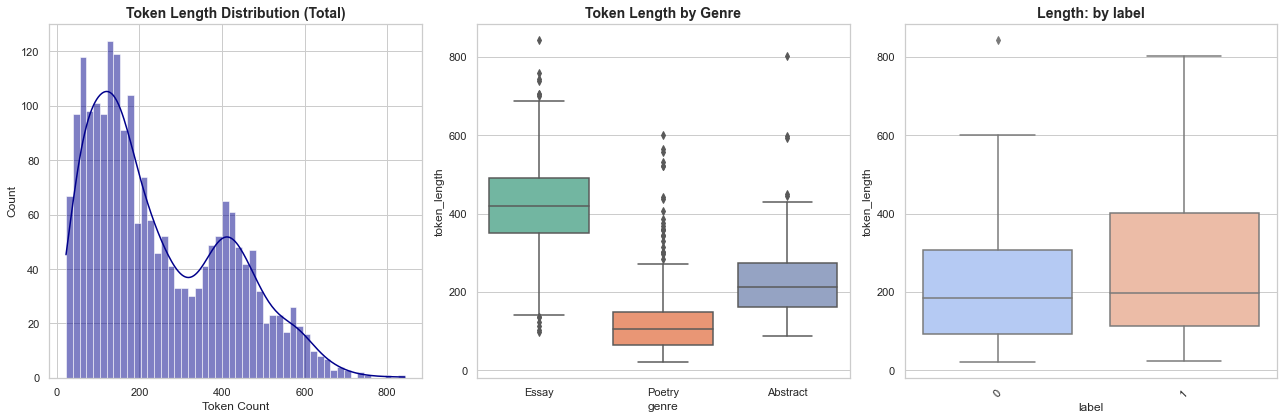


📈 [장르별 길이 통계]
          count   mean    std   min    25%    50%    75%    max
genre                                                          
Abstract  378.0  223.3   86.6  88.0  162.0  213.0  272.8  801.0
Essay     771.0  416.6  122.5  99.0  350.0  420.0  489.5  843.0
Poetry    945.0  116.9   72.4  22.0   65.0  106.0  149.0  601.0


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
from tqdm import tqdm
import os
import glob

# ==========================================
# 1. 파일 경로 설정 (여기를 수정하세요!)
# ==========================================
# jsonl 파일 3개가 들어있는 '폴더 경로'를 입력해주세요.
# 예: r"C:\Users\SeungWoo\Downloads\katfishnet-main\katfish_dataset"
base_path = r"C:\Users\SeungWoo\Downloads"

print(f"📂 데이터 폴더 경로: {base_path}")

# 읽어올 파일 목록과 장르 매핑
target_files = {
    "essay.jsonl": "Essay",
    "poetry.jsonl": "Poetry",
    "abstract.jsonl": "Abstract"
}

# ==========================================
# 2. 데이터 로드 및 병합 (Merge)
# ==========================================
merged_data = []

print("\n🔄 파일 로드 및 병합 시작...")

for filename, genre_name in target_files.items():
    full_path = os.path.join(base_path, filename)
    
    if os.path.exists(full_path):
        try:
            # JSONL 파일 읽기
            temp_df = pd.read_json(full_path, lines=True)
            
            # 'genre' 컬럼 추가 (어떤 파일에서 왔는지 표시)
            temp_df['genre'] = genre_name
            
            # 리스트에 추가
            merged_data.append(temp_df)
            print(f"   ✅ {filename} 로드 성공 ({len(temp_df)}행) -> 장르: {genre_name}")
            
        except Exception as e:
            print(f"   ❌ {filename} 로드 실패: {e}")
    else:
        print(f"   ⚠️ 파일을 찾을 수 없음: {filename} (경로를 다시 확인해주세요)")

# 하나로 합치기
if merged_data:
    df = pd.concat(merged_data, ignore_index=True)
    print(f"\n🎉 전체 데이터 병합 완료! 총 {len(df)}행")
else:
    print("❌ 로드된 데이터가 없습니다. 경로를 확인해주세요.")
    df = pd.DataFrame()

# ==========================================
# 3. 데이터 구조 확인
# ==========================================
if not df.empty:
    print(f"\n📑 컬럼 목록: {df.columns.tolist()}")
    
    # 상위 20개 샘플 (장르별로 섞여있는지 확인)
    print("\n🔍 [상위 20개 샘플 - 랜덤 샘플링]")
    display(df.sample(20)) # 랜덤으로 뽑아서 다양한 장르 확인

    # 분포 확인
    print("\n📊 [데이터 분포]")
    print(f"1. 장르별 분포:\n{df['genre'].value_counts()}")
    
    # 라벨 컬럼 찾기 (논문에 따르면 'label' 또는 'source'일 가능성 높음)
    # 보통 'human' vs 'model_name' 혹은 'label': 'human'/'machine'
    possible_label_cols = [c for c in df.columns if c in ['label', 'source', 'model', 'author']]
    for col in possible_label_cols:
        print(f"\n2. {col} 컬럼 분포:\n{df[col].value_counts()}")

    # ==========================================
    # 4. 토큰 길이 계산 (Korean RoBERTa)
    # ==========================================
    # 한국어 특화 모델 사용
    model_ckpt = "klue/roberta-base"
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    print(f"\n🤖 한국어 토크나이저({model_ckpt}) 로드 완료")

    token_counts = []
    print("⏳ 토큰 길이 계산 중...")
    
    # 텍스트 컬럼 찾기 (보통 'text', 'content', 'document' 중 하나)
    text_col = [c for c in df.columns if c in ['text', 'content', 'body']][0]
    print(f"   └ 분석 대상 텍스트 컬럼: '{text_col}'")

    for text in tqdm(df[text_col]):
        tokens = tokenizer(str(text), add_special_tokens=True, truncation=False)['input_ids']
        token_counts.append(len(tokens))

    df['token_length'] = token_counts

    # ==========================================
    # 5. 시각화 (장르별 특징 반영)
    # ==========================================
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(18, 6))

    # 5-1. 전체 길이 분포
    plt.subplot(1, 3, 1)
    # 시(Poetry)는 짧고 논문은 길기 때문에 로그 스케일을 쓰거나 범위를 넓게 잡아야 함
    sns.histplot(df['token_length'], bins=50, kde=True, color='darkblue')
    plt.title('Token Length Distribution (Total)', fontsize=14, fontweight='bold')
    plt.xlabel('Token Count')

    # 5-2. 장르별 길이 비교 (Boxplot)
    plt.subplot(1, 3, 2)
    sns.boxplot(x='genre', y='token_length', data=df, palette="Set2")
    plt.title('Token Length by Genre', fontsize=14, fontweight='bold')
    
    # 5-3. Human vs Machine 비교 (라벨 컬럼이 있는 경우)
    if possible_label_cols:
        target_label = possible_label_cols[0] # 첫 번째 후보 사용
        plt.subplot(1, 3, 3)
        sns.boxplot(x=target_label, y='token_length', data=df, palette="coolwarm")
        plt.title(f'Length: by {target_label}', fontsize=14, fontweight='bold')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # ==========================================
    # 6. 요약 통계
    # ==========================================
    print("\n📈 [장르별 길이 통계]")
    print(df.groupby('genre')['token_length'].describe().round(1))